# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Soil hydraulics with Dumux-rosi

In [ ]:
import timeit

import matplotlib.pyplot as plt
import numpy as np
from richards_flat import RichardsFlatWrapper  # Python part of cylindrical
from rosi_richards_cyl import RichardsCylFoam  # C++ part (Dumux binding), macroscopic soil model

import functional.van_genuchten as vg
import visualisation.vtk_plot as vp  # for quick vizualisations
from richards import RichardsWrapper  # Python part  
from rosi_richards import (
    RichardsSP,
    RichardsSPnum,  # C++ part (Dumux binding)
)

In [ ]:
def sinusoidal(t: float) -> float:
    """ 
    Sinusoidal function (used for transpiration) (integral over one day is 1).
    
    Args:
        t (float): Time [days].
    
    Returns:
        float: Sinusoidal value at time t.
    """
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.

### Size and Resolution of the domain

Computed bounding box tree with 249 nodes for 125 grid entities in 5.4966e-05 seconds.
Computed bounding box tree with 249 nodes for 125 grid entities in 2.9568e-05 seconds.
 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.


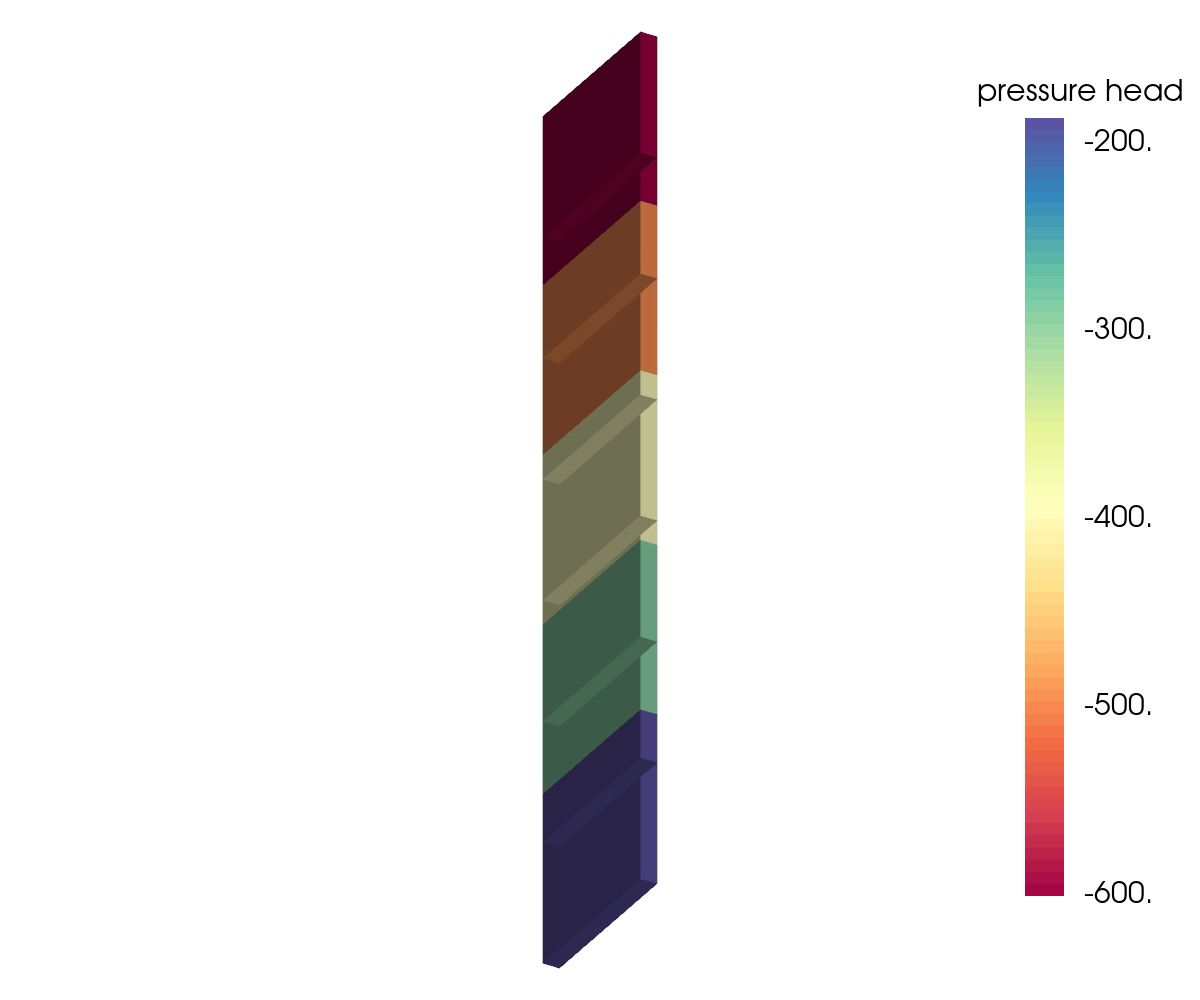

Computed bounding box tree with 249999 nodes for 125000 grid entities in 0.0449939 seconds.
Computed bounding box tree with 249999 nodes for 125000 grid entities in 0.0418838 seconds.


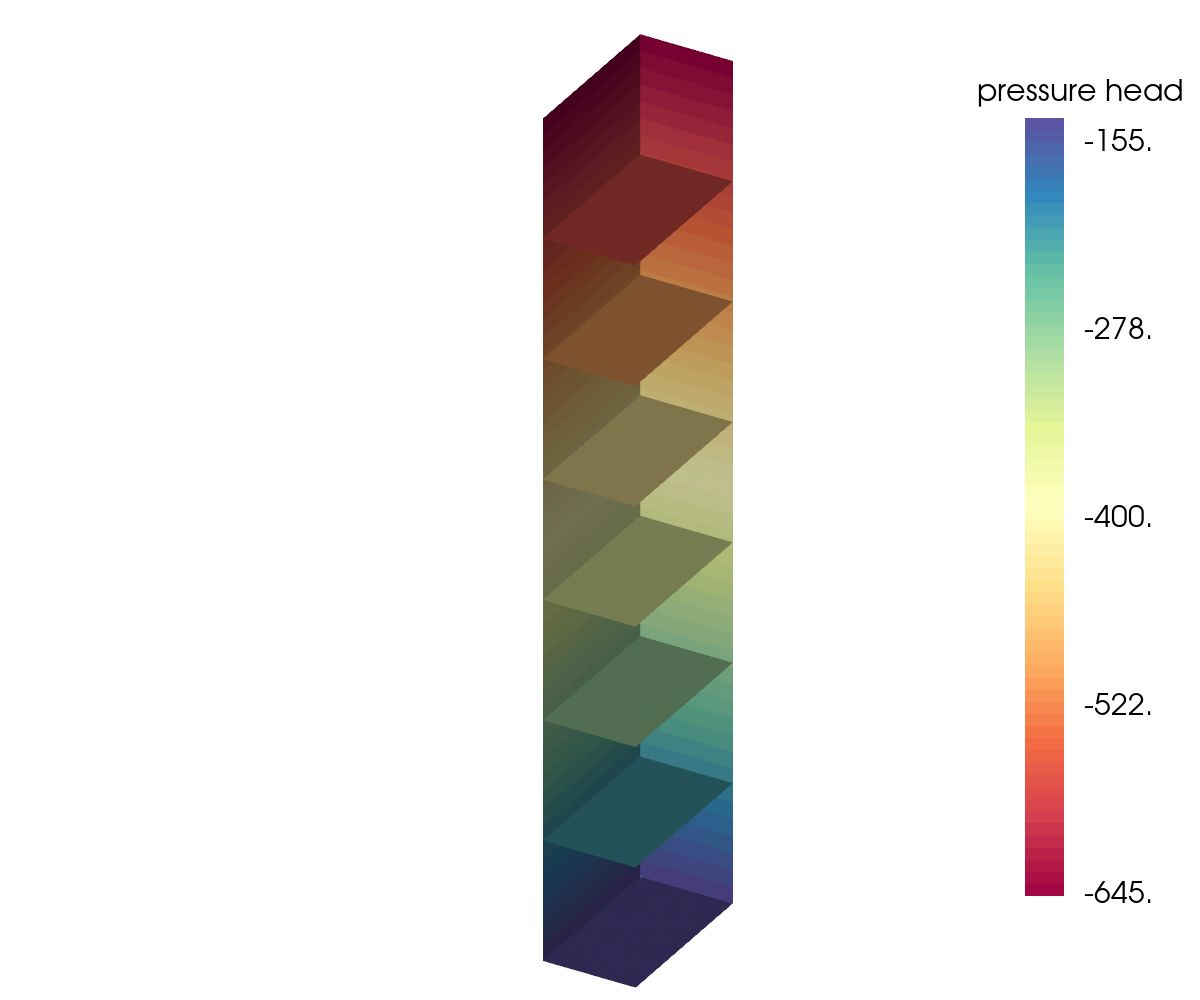

Computed bounding box tree with 99 nodes for 50 grid entities in 3.7488e-05 seconds.
Computed bounding box tree with 99 nodes for 50 grid entities in 1.5664e-05 seconds.


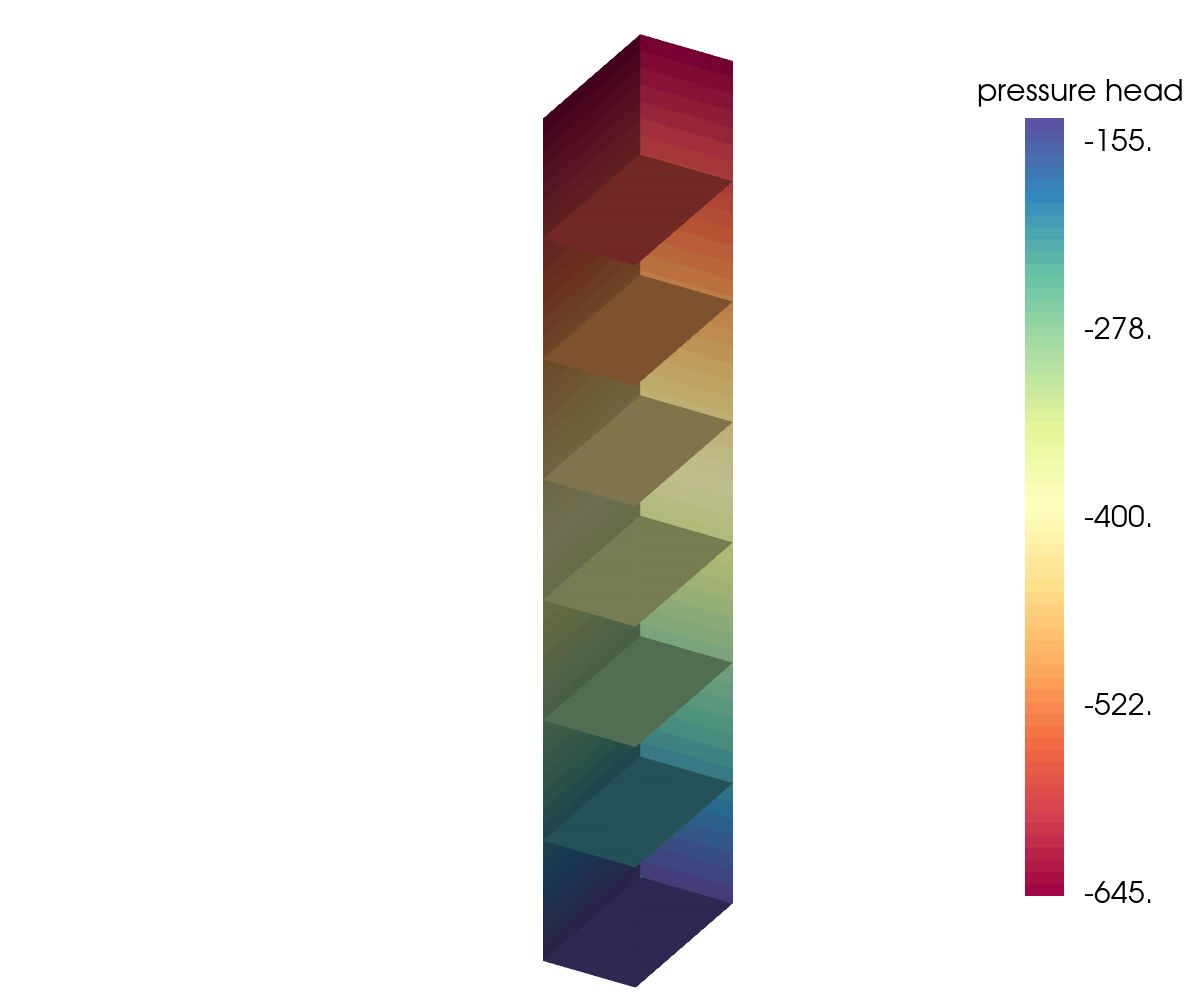

In [ ]:
def visualize_soil(min_b: list[float], max_b: list[float], cell_number: list[int]) -> None:
    """
    Create and visualize a soil domain with given boundaries and resolution.

    Args:
        min_b (list[float], length 3): Minimum boundaries of the soil domain [cm].
        max_b (list[float], length 3): Maximum boundaries of the soil domain [cm].
        cell_number (list[int], length 3): Number of cells in each dimension.
    
    Notes:
        - The soil is initialized with a homogeneous pressure head of -400 cm.
        - The van Genuchten parameters for loam soil are used.
        - The top and bottom boundary conditions are set to "noFlux".
    """
    loam = [0.08, 0.43, 0.04, 1.6, 50] # van Genuchten parameters for loam soil; [theta_r (residual water content), theta_s (saturated water content), alpha, n, Ks]
    s = RichardsWrapper(RichardsSPnum())
    s.initialize()
    s.createGrid(min_b, max_b, cell_number)
    s.setHomogeneousIC(-400., equilibrium = True)  # cm pressure head   
    s.setVGParameters([loam])
    s.setTopBC("noFlux")  
    s.setBotBC("noFlux")
    s.initializeProblem()      
    vp.plot_soil(s, "pressure head", min_b, max_b, cell_number, interactiveImage = False)

min_b = [-50., -5., -500.] # size [cm]  
max_b = [50., 5., 0.] # size [cm]  
cell_number = [5, 5, 5] # resolution
visualize_soil(min_b, max_b, cell_number)

max_b = [50., 50., 0.] # size [cm]  
cell_number = [50, 50, 50] # resolution
visualize_soil(min_b, max_b, cell_number)

max_b = [50., 50., 0.] # size [cm]  
cell_number = [1, 1, 50] # resolution <= 1D
visualize_soil(min_b, max_b, cell_number)

### Time step

Change in time step dt will lead to more/ less convergence. Smaller time steps means higher resolution and therefore averages over a smaller timeframe (check numerical stability and convergence)

Computed bounding box tree with 299 nodes for 150 grid entities in 0.0007853 seconds.
Computed bounding box tree with 299 nodes for 150 grid entities in 4.51e-05 seconds.
 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
Computed bounding box tree with 299 nodes for 150 grid entities in 7.09e-05 seconds.
Computed bounding box tree with 299 nodes for 150 grid entities in 3.21e-05 seconds.


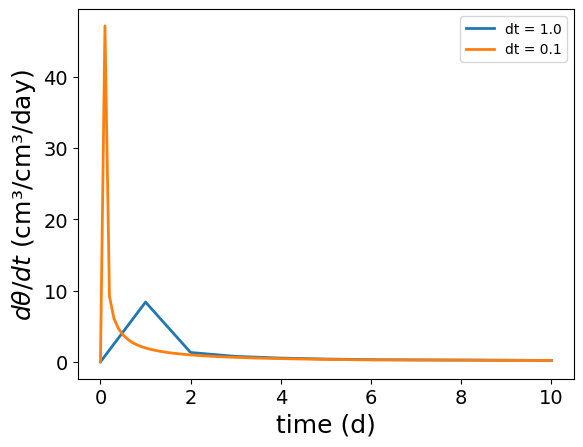

In [ ]:

def run_simulation(sim_time: tuple[float, int], dt: tuple[float, int]) -> None:
    """
    Run a soil water simulation and plot the rate of change of soil water content in a 1D soil column.

    Args:
        sim_time (float, int): Total simulation time.
        dt (float, int): Time step for the simulation.

    Notes:
        - The soil domain hardcoded with specific boundaries and resolution.
        - The soil is initialized with a homogeneous pressure head of -400 cm.
        - The van Genuchten parameters for loam soil are used.
        - The top boundary condition is set to "atmospheric" with specified atmospheric values.
        - The bottom boundary condition is set to "constantPressure" with a value of 0 cm.
        - The function plots the change in water content over time.
    """
    min_b = [-1., -1., -150.] # size [cm]  
    max_b = [0., 0., 0.] # size [cm]  
    cell_number = [1, 1, 150] # resolution --> 1D soil column

    # params: theta_r (residual water content [cm3/cm3]), theta_s (saturated water content [cm3/cm3]), alpha (van Genuchten parameter [1/cm], 
    # inverse of air entry suction), n (van Genuchten parameter [-], pore-size distribution), Ks (saturated hydraulic conductivity [cm/day])
    loam = [0.08, 0.43, 0.04, 1.6, 50]

    top_boundary_condition = "atmospheric"
    # row 0: time points [day], 0: start, 0,1, 0,1: instantaneous change, 0,3: end of short event, 1.e6: far future
    # row 1: atmospheric values [cm/day], 10: strong rainfall, -0,1: slight evaporation, 0: no flux
    atmospheric_value = [[0., 0.1, 0.1, 0.3, 1.e6], [10., 10., -0.1, -0.1, 0.]] # [day] and [cm/day]

    bot_boundary_condition = "constantPressure"
    bot_value = 0
    top_value = 0. # [cm]

    s = RichardsWrapper(RichardsSPnum()) 
    s.initialize()     
    s.createGrid( min_b, max_b, cell_number) # creates the grid
    s.setHomogeneousIC(-400., equilibrium = True)  # cm pressure head   
    s.setVGParameters([loam])    
    s.setTopBC(top_boundary_condition, top_value, atmospheric_value) # set boundary condition
    s.setBotBC(bot_boundary_condition, bot_value)
    s.initializeProblem() # prepares the problem for solving

    x_, y_ = [0], [0]
    N = int(np.ceil(sim_time/dt))
    theta_i = s.getWaterContent() # initial water content/ water content at previous time step

    for i in range(N):
        s.solve(dt) 
        theta_j = s.getWaterContent() # water content at current time step
        x_.append(dt * (i + 1))
        y_.append((theta_j.sum() - theta_i.sum())/dt) # rate of change of water content [cm3/cm3/day]
        theta_i = theta_j.copy()

    plt.plot(x_, y_, linewidth = 2, label = f"dt = {dt}")
    plt.ylabel(r"$d\theta/dt$ (cm³/cm³/day)", fontsize = 18) #raw string: allows for LaTex commands with backslashes
    plt.xlabel('time (d)', fontsize = 18)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)


plt.figure()
run_simulation(10., 1.)
run_simulation(10., 0.1)
plt.legend()
plt.show()

### The Van Genuchten Model

The constitutive equations are described the Van Genuchten model, giving the soil retention curve, hydraulic conductivities or matrix flux potentials. The following script show example parametrisations of various soil types. 

theta_R: 0.045, theta_S: 0.43, alpha: 0.15, n: 3, m: 0.6666666666666667, Ksat: 1000


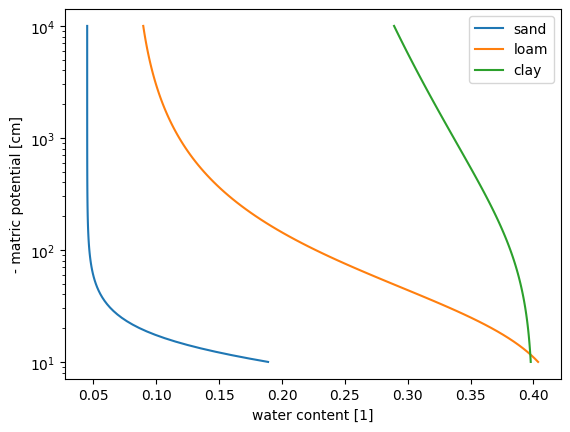

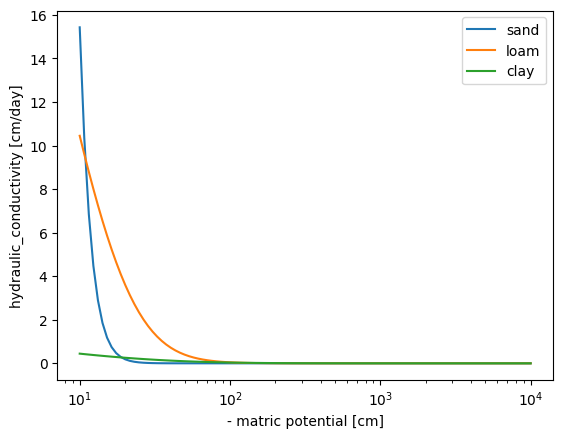

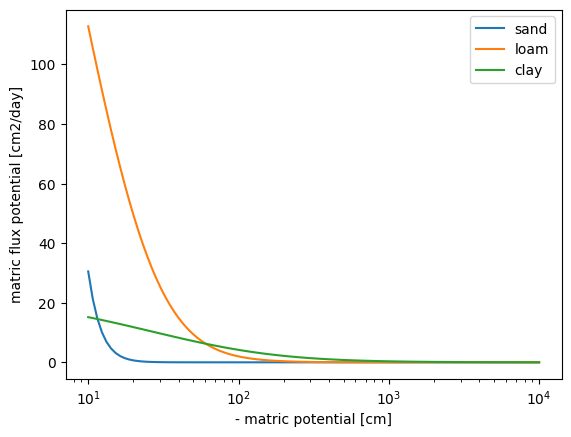

In [3]:
# Define van Genuchten parameters for sand, loam and clay  
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
sand =  vg.Parameters([0.045, 0.43, 0.15, 3, 1000])
loam =  vg.Parameters([0.08, 0.43, 0.04, 1.6, 50])
clay =  vg.Parameters([0.1, 0.4, 0.01, 1.1, 10])

print(f"theta_R: {sand.theta_R}, theta_S: {sand.theta_S}, alpha: {sand.alpha}, n: {sand.n}, m: {sand.m}, Ksat: {sand.Ksat}")

vg.plot_retention_curve(sand, label_ = "sand")
vg.plot_retention_curve(loam, label_ = "loam")
vg.plot_retention_curve(clay, label_ = "clay")
plt.legend()

plt.show()
vg.plot_hydraulic_conductivity(sand, label_ = "sand")
vg.plot_hydraulic_conductivity(loam, label_ = "loam")
vg.plot_hydraulic_conductivity(clay, label_ = "clay")
plt.legend()
plt.show()

# ability of soil to transmit water under a given matric potential
vg.plot_matric_flux_potential(sand, label_ = "sand")
vg.plot_matric_flux_potential(loam, label_ = "loam")
vg.plot_matric_flux_potential(clay, label_ = "clay")
plt.legend()

Therefore, the retention curve relates matric potential and water content and vice versa: 

In [4]:
def pressure_head(theta: float, sp: vg.Parameters) -> float:
    """ 
    Compute the pressure head (h) corresponding to a given volumetric water content (theta)
    using the van Genuchten soil water retention model.
    
    Args:
        theta (float): Volumetric water content [cm³/cm³]. Must satisfy sp.theta_R < theta <= sp.theta_S.
        sp (vg.Parameters): Van Genuchten parameters.

    Returns:
        h (float): Pressure head corresponding to theta [cm], negative in unsaturated soil.
    """
    assert theta > sp.theta_R # ensure theta is above residual water content
    assert theta <= sp.theta_S # ensure theta does not exceed saturated water content
    return -pow(pow((sp.theta_S - sp.theta_R) / (theta - sp.theta_R), (1. / sp.m)) - 1., 1. / sp.n) / sp.alpha

def theta(h: float, sp: vg.Parameters) -> float:
    """
    Compute the volumetric water content (theta) corresponding to a given pressure head (h)
    using the van Genuchten soil water retention model.

    Args:
        h (float): Pressure head [cm], negative in unsaturated soil.
        sp (vg.Parameters): Van Genuchten parameters.

    Returns:
        float: Volumetric water content (theta) [cm³/cm³] at a given pressure head (h) according to the van Genuchten model
    """
    return sp.theta_R + (sp.theta_S - sp.theta_R) / pow(1. + pow(sp.alpha * abs(h), sp.n), sp.m) # pow is exponentiation (base, exponent)
    

In [5]:
wilting_point = -15000 # cm
field_capacity = -100 # maximum water retention capacity after excess water has drained away [cm]

PAW = theta(field_capacity, loam) - theta(wilting_point, loam)  # plant available water (PAW) --> between field capacity and wilting point
print(f"Plant Available Water (PAW) for loam soil: {PAW:.4f} cm³/cm³")

Plant Available Water (PAW) for loam soil: 0.1390 cm³/cm³


In [6]:
print(vg.effective_saturation(-500, loam))
print(vg.hydraulic_conductivity(-500, loam))

0.16521066502868686
0.00019401073323171826


### Multi-layered soil

In layered soils (i.e. contrasting parametrisations of the Van Genuchten model), the same matric potential will lead to different values for the water content, leading to jumps in water content across the profile.

Computed bounding box tree with 299 nodes for 150 grid entities in 0.0002298 seconds.
Computed bounding box tree with 299 nodes for 150 grid entities in 2.96e-05 seconds.


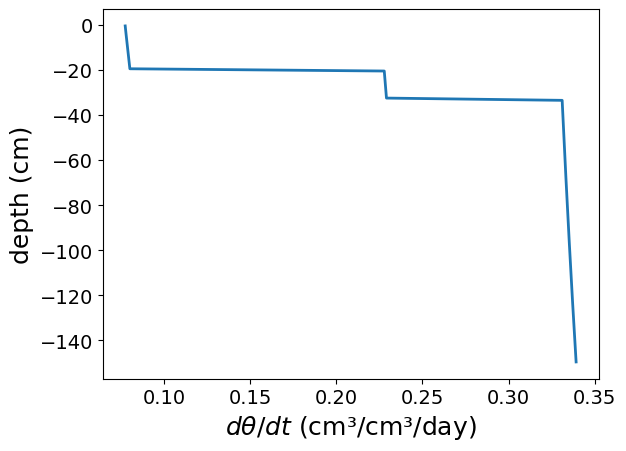

In [7]:
def visualize_soil(soil: list[list[float]], layers_ID: list[int], layers_pos: list[float]) -> None:
    """
    Visualize the vertical soil water content profile of a layered soil column
    using the Richards equation solver.

    Args:
        soil (list[list[float]]): List of van Genuchten parameters for each soil layer.
        layers_ID (list[int]): Sequence of layer identifiers corresponding to the indices in `soil` 
                               that define which soil type applies between consecutive `layers_pos`.
        layers_pos (list[float]): List of depth positions (cm) for each layer interface

    Notes:
        - The soil column is defined from -150 cm to 0 cm depth with 150 cells.
        - The initial condition is set to a homogeneous pressure head of -400 cm.
        - The top and bottom boundary conditions are set to "noFlux".
    """
    
    # define soil domain; 1D soil column
    min_b = [-1., -1., -150.] # size [cm]  
    max_b = [0., 0., 0.] # size [cm]  
    cell_number = [1, 1, 150] # resolution

    s = RichardsWrapper(RichardsSPnum()) 
    s.initialize()     
    s.createGrid(min_b, max_b, cell_number)      
    s.setHomogeneousIC(-400., equilibrium = True)  # cm pressure head   
    s.setVGParameters(soil)
    s.setTopBC("noFlux")  
    s.setBotBC("noFlux")
    # define soil layers
    s.setLayersZ(layers_ID, layers_pos) # assign soil types to layers

    s.initializeProblem()      
    
    s.solve(1/24/3600) # Solves for one very small timestep (1 second), just to update the internal states.
    points = s.getDofCoordinates()
    theta = s.getWaterContent() 
    
    plt.figure(0)
    plt.plot(theta, points[:, 2], linewidth = 2)
    plt.xlabel(r"$d\theta/dt$ (cm³/cm³/day)", fontsize = 18)
    plt.ylabel('depth (cm)', fontsize = 18)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()  

# Define Mualem van Genuchten parameters for Selhausen soil profile according to Bauer et al. (2011, table 3, \url{https://doi.org/10.1007/s10533-011-9583-1})
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
sand =  [0.045, 0.43, 0.15, 3, 1000]

l1 = [0.008, 0.389, 0.012, 1.97, 91.68]  # 0-20 cm 
l2 = [0.008, 0.389, 0.023, 1.23, 63.36]  # 20-33 cm
l3 = [0.008, 0.389, 0.01, 1.1, 10]  # 33-57 cm
l4 = [0.008, 0.389, 0.01, 1.1, 10]  # 57-120 cm
soil = [l1, l2, l3, l4] # Combine the hydraulic conductivity vectors from all soil layers to define soil type for simulation  

layers_ID = [4, 4, 3, 3, 2, 2, 1, 1]  
layers_pos = [-120., -57., -57., -33., -33, -20, -20, 0] 

visualize_soil(soil, layers_ID, layers_pos)

### Boundary conditions
1. Neumann boundary conditions (flux [cm/day], volume per surface per day)
2. Dirichlet boundary conditions (matric potential [cm])

Computed bounding box tree with 299 nodes for 150 grid entities in 0.0001773 seconds.
Computed bounding box tree with 299 nodes for 150 grid entities in 6.09e-05 seconds.


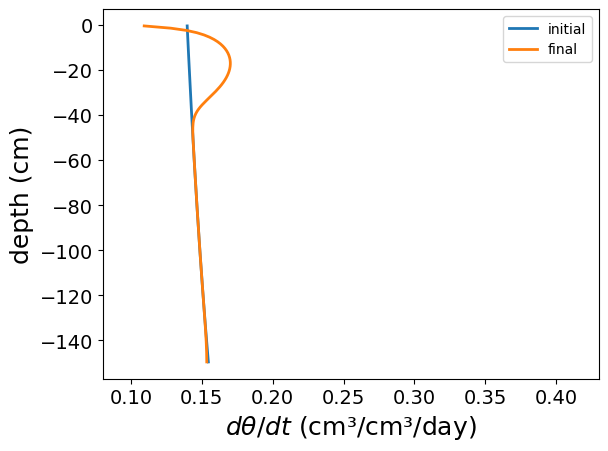

In [8]:

def run_simulation(top_boundary_condition: str,
                   bot_boundary_condition: str,
                   top_value: float,
                   atmospheric_value: list[list[float]],
                   bot_value: float,
                   initial_pressure: float,
                   at_equilibrium: bool
                   ) -> None:
    """
    Simulate 1D vertical water flow in a loam soil column using the Richards equation.

    Args:
        top_boundary_condition (str): Type of top boundary condition ("noFlux", "constantFlux", "atmospheric", "constantPressure").
        bot_boundary_condition (str): Type of bottom boundary condition ("noFlux", "constantFlux", "freeDrainage", "constantPressure").
        top_value (float): Value associated with the top boundary condition (e.g., flux rate [cm/day] or pressure head [cm]).
        atmospheric_value (list[list[float]]): Time series for atmospheric boundary condition (if applicable).
        bot_value (float): Value associated with the bottom boundary condition (e.g., flux rate [cm/day] or pressure head [cm]).
        initial_pressure (float): Initial pressure head in the soil column [cm].
        at_equilibrium (bool): Whether to initialize the soil at equilibrium.
    """
    # define soil domain; 1D soil column; loamy soil
    min_b = [-1., -1., -150.] # size [cm]  
    max_b = [0., 0., 0.] # size [cm]  
    cell_number = [1, 1, 150] # resolution
    loam = [0.08, 0.43, 0.04, 1.6, 50]
    
    s = RichardsWrapper(RichardsSPnum()) 
    s.initialize()     
    s.createGrid( min_b, max_b, cell_number)      
    s.setHomogeneousIC(initial_pressure, equilibrium = at_equilibrium)  # cm homogenous initial pressure head; at equilibrium with gravity True/False
    s.setVGParameters([loam])
    
    s.setTopBC(top_boundary_condition, top_value, atmospheric_value)  
    s.setBotBC(bot_boundary_condition, bot_value)
    
    s.initializeProblem()   
    points0 = s.getDofCoordinates() # coordinates soil surface
    theta0 = s.getWaterContent() # initial water content
    s.solve(10.) 
    points = s.getDofCoordinates() # depth coordinates
    theta = s.getWaterContent() # volumetric water contents
    
    plt.figure(0)
    plt.plot(theta0, points0[:, 2], linewidth = 2, label = "initial")
    plt.plot(theta, points[:, 2], linewidth = 2, label = "final")
    plt.xlabel(r"$d\theta/dt$ (cm³/cm³/day)", fontsize = 18)
    plt.ylabel('depth (cm)', fontsize = 18)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlim(loam[0], loam[1]) 
    plt.legend()
    plt.show()  

atmospheric_value = []
top_value = 0.
bot_value = 0. # default

# Neumann options: "noFlux", "constantFlux", bottom BC: "freeDrainage" advanced options: "atmospheric" 
# Dirichlet options: "constantPressure" 

# Neumann BC. flux is lowered if it cannot be respected
# top_boundary_condition = "noFlux"   
# top_boundary_condition = "constantFlux"
# top_value = -1. # [cm/day]
# top_value = 1. #[cm/day]
bot_boundary_condition = "freeDrainage"
# bot_boundary_condition = "noFlux"   
# bot_boundary_condition = "constantFlux"
# bot_value = 1. # [cm/day]

# Neumann BC from environmental variables
top_boundary_condition = "atmospheric"
atmospheric_value = [[0., 0.1, 0.1, 0.3, 1.e6], [10., 10., -0.1, -0.1, 0.]] # [day] and [cm/day]

# Dirichlet BC.
# top_boundary_condition = "constantPressure"
# top_value = -1500. # [cm]
# bot_boundary_condition = "constantPressure"
# bot_value = 0. # [cm]

initial_pressure = -400
at_equilibrium = True

run_simulation(top_boundary_condition, bot_boundary_condition, top_value, atmospheric_value, bot_value, initial_pressure, at_equilibrium)


### Select outputs
1. Specific time points
2. Specific areas
3. Specific variables

Computed bounding box tree with 7499 nodes for 3750 grid entities in 0.0013891 seconds.
Computed bounding box tree with 7499 nodes for 3750 grid entities in 0.0011808 seconds.
measurement_point 3523


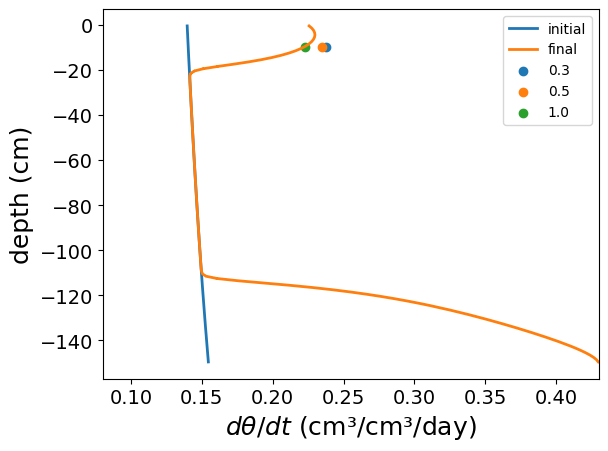

In [9]:

def run_simulation(meas_time: list[float], meas_coord: list[float]) -> None:
    """
    Run a simulation of soil water dynamics using the Richards equation and record water content at a specific depth.

    Args:
        meas_time (list[float]): List of measurement times [days] to record water content.
        meas_coord (list[float]): List of measurement coordinates [cm].
    """
    
    # define soil domain; loamy soil
    min_b = [-5., -5., -150.] # size [cm]  
    max_b = [0., 0., 0.] # size [cm]  
    cell_number = [5, 5, 150] # resolution
    loam = [0.08, 0.43, 0.04, 1.6, 50]

    s = RichardsWrapper(RichardsSPnum()) 
    s.initialize()     
    s.createGrid( min_b, max_b, cell_number)      
    s.setHomogeneousIC(-400., equilibrium = True)  # homogenous initial pressure head cm; at equilibrium with gravity 
    s.setVGParameters([loam])

    # define boundary conditions
    atmospheric_value = []
    top_value = 0.
    bot_value = 0. # default
    top_boundary_condition = "atmospheric"
    atmospheric_value = [[0., 0.1, 0.1, 0.3, 1.e6], [10., 10., -0.1, -0.1, 0.]] # [day] and [cm/day]
    bot_boundary_condition = "constantPressure"
    bot_value = 0. # [cm]

    s.setTopBC(top_boundary_condition, top_value, atmospheric_value)  
    s.setBotBC(bot_boundary_condition, bot_value)

    s.initializeProblem()   

    ##
    measurement_point = s.pick(meas_coord) # convert coordinates to index of closest grid point
    print("measurement_point", measurement_point)
    ##
    
    x_, y_ = [], [] # times for plotting; water contents at measurement point
    time = 0.
    points0 = s.getDofCoordinates()
    theta0 = s.getWaterContent() # initial water content
    
    for dt in np.diff(meas_time):
        s.solve(dt) #10.) 
        time += dt
        x_.append(time)
        output = s.getWaterContent()[measurement_point] # s.getSolutionHead()[measurement_point]
        y_.append(output)
        
    pointsf = s.getDofCoordinates()
    thetaf = s.getWaterContent() 
    
    plt.figure()
    plt.plot(theta0, points0[:, 2], linewidth = 2, label = "initial")
    plt.plot(thetaf, pointsf[:, 2], linewidth = 2, label = "final")
    for i in range(len(x_)):
        plt.scatter( y_[i], meas_coord[2],label=x_[i])            
    plt.xlabel(r"$d\theta/dt$ (cm³/cm³/day)", fontsize = 18)
    plt.ylabel('depth (cm)', fontsize = 18)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlim(loam[0], loam[1]) 
    plt.legend()
    plt.show()  

meas_time = [0., 0.3, 0.5, 1.] # days
meas_coord = [-1., -1., -10.] # x, y, z coordinate with regards to the upper-left corner of the soil domaine
run_simulation(meas_time, meas_coord)

## Simulations: 

1. Infiltration into an initially dry soil

2. Evaporation from an initially moist soil 

3. Infiltration and evaporation from a multi-layered soil

4. Water uptake by a single root in 1D axisymmetric geometry

Computed bounding box tree with 199 nodes for 100 grid entities in 0.000176803 seconds.
Computed bounding box tree with 199 nodes for 100 grid entities in 3.37e-05 seconds.


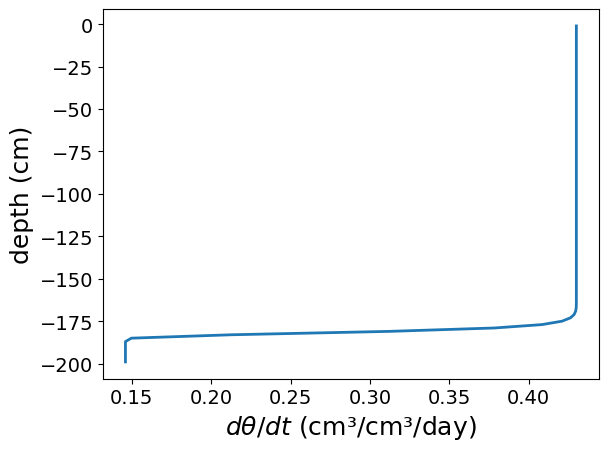

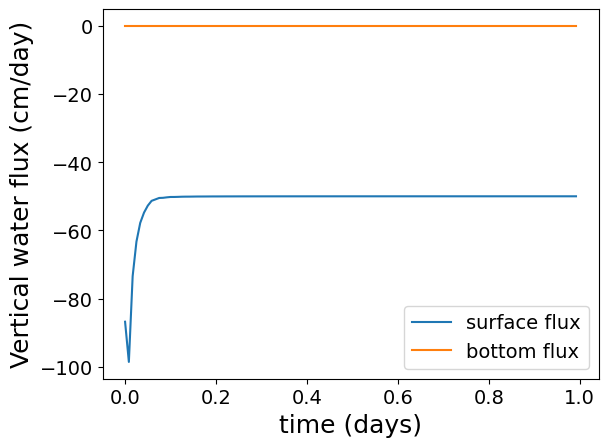

In [10]:
# Define van Genuchten parameters for sand, loam and clay  
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
sand = [0.045, 0.43, 0.15, 3, 1000]
loam = [0.08, 0.43, 0.04, 1.6, 50]
clay = [0.1, 0.4, 0.01, 1.1, 10]

soil = loam  # Select soil type for simulation  

sim_time = 1 # day
dt = 720 / (24 * 3600)  # time step [days]   

# Solve the Richards equation using the Python wrapper of dumux-rosi
s = RichardsWrapper(RichardsSPnum()) 
s.initialize()

# set boundary conditions; (type: atmospheric, surface ponding limit [cm]: 0.5; atmospheric values: [[time points], [atmospheric values]])
s.setTopBC("atmospheric", 0.5, [[-1., 1.e10], [100., 100.]])  #  [cm/day]; atmospheric is with surface run-off   
s.setBotBC("freeDrainage")

N = 100 # number of layers
s.createGrid([-5., -5., -200.], [5., 5., 0.], [1, 1, N])  # [cm]

s.setHomogeneousIC(-400.)  # cm homogenous initial pressure head   
s.setVGParameters([soil])
s.initializeProblem()

s.setCriticalPressure(-15000) # wilting point
s.ddt = 1.e-5  # initial dumux time step [days]  

top_ind = s.pick([0., 0., -0.5]) # picks the index of the grid cell closest to the given coordinates (surface)
bot_ind = s.pick([0., 0., -199.5]) # (bottom)
top_new, bot_new, soil_times = [], [], []  

N = int(np.ceil(sim_time / dt)) 
for i in range(0, N):
    t = i * dt  # current simulation time   
    soil_times.append(t)  
    s.solve(dt)  
    velocities = s.getVelocities_() # extracts darcy flux vectors [cm/day]
    top_new.append(velocities[top_ind]) # infiltration/ evaporation rates at surface
    bot_new.append(velocities[bot_ind]) # drainage rates at bottom

top_new = np.array(top_new)  
bot_new = np.array(bot_new)
soil_times = np.array(soil_times)  

# Extract and plot numerical solution  
points = s.getDofCoordinates()
theta = s.getWaterContent()
plt.figure(0)
plt.plot(theta, points[:, 2], linewidth = 2) # plots final theta vs. depth profile after simulation
plt.xlabel(r"$d\theta/dt$ (cm³/cm³/day)", fontsize = 18)
plt.ylabel('depth (cm)', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()  

plt.figure(1) # plots vertical fluxes at top and bottom boundary over time
plt.plot(soil_times, top_new[:, 2], label = "surface flux")
plt.plot(soil_times, bot_new[:, 2], label = "bottom flux")
plt.xlabel('time (days)', fontsize = 18)
plt.ylabel('Vertical water flux (cm/day)', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.show()  


### Evaporation from an initially moist soil 

This example reproduces the evaporation example M2.2 from Schnepf et al. (2023). Water evaporated from the surface of an initially moist soil. Only the vertical water movement is considered. Atmospheric boundary conditions are set at the upper boundary and a free drainage boundary condition is set at the lower boundary. There is an analytical solution for this simple example, which can optionally be plotted for comparison.

Computed bounding box tree with 199 nodes for 100 grid entities in 5.6314e-05 seconds.
Computed bounding box tree with 199 nodes for 100 grid entities in 2.4392e-05 seconds.
initial water volume 1791.9056501866478


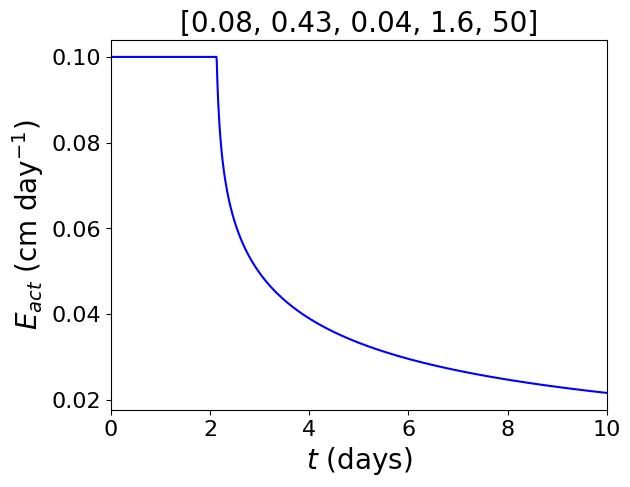

In [ ]:
soil = loam  # Select soil type for simulation  
sim_time = 10
N = 2000 # number of time steps
dt = sim_time / N  # time step [days]  
ic = -200 # cm initial condition: initial pressure head
evap = -0.1  # [cm/day] Potential evaporation rate

s = RichardsWrapper(RichardsSP())  
s.initialize()

s.setTopBC("atmospheric", 0.5, [[0., 1.e10], [evap, evap]])  #  [cm/day]    
# s.setTopBC("flux", evap)  #  [cm/day]
# s.setTopBC("constantPressure", -10000)
s.setBotBC("freeDrainage")  

NZ = 100 # 1399
s.createGrid([-5., -5., -100.], [5., 5., 0.], [1, 1, NZ])  # [cm] --> 1D vertical flow  
# vols = (100. / NZ) * np.ones((NZ,)) * 100.  # cm3
s.setVGParameters([soil])  
s.setHomogeneousIC(ic)  # cm pressure head  
# s.setParameter("Problem.EnableGravity", "false")

s.initializeProblem()  
s.setCriticalPressure(-10000) # dry soil limit; below this suction & evaporation is heavily reduced
s.setRegularisation(1.e-6, 0.) # prevents numerical instability when switching between saturated and unsaturated zones
idx_top = s.pickCell([0.0, 0.0, 0.0])  # index to watch surface flux, grid cell at soil surface 
initial_water = s.getWaterVolume() # initial water volume in the soil domain [cm3]
print(f"initial water volume: {initial_water}")

s.ddt = 1.e-5  # initial Dumux time step [days] 
maxDt = 1.  # maximal Dumux time step [days]  

x_, y_ = [], []
for i in range(0, N):  
    s.solve(dt, maxDt)  
    f = s.getNeumann(idx_top)  # real evaporation rate at surface [cm/day] = actual Neumann flux
    # f = s.getSolutionHeadAt(idx_top)   
    #   current_water = s.getWaterVolume()
    #   f = (initial_water - current_water) / dt / 1.e2
    #   print(current_water, f)
    #   initial_water = current_water
    x_.append(s.simTime)
    y_.append(f)  

# Extract and plot numerical solution
plt.plot(x_, y_, 'b') 
plt.ylabel('$E_{act}$ (cm day$^{-1}$)', fontsize = 20)
plt.xlim(0, 10)
plt.title(soil, fontsize = 20)
plt.xlabel('$t$ (days)', fontsize = 20)
plt.ylabel('$E_{act}$ (cm day$^{-1}$)', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.show()  


### Infiltration and evaporation from a multi-layered soil

This example builds on the infiltration and evaporation problem M2.1 and M2.2 from Schnepf et al. (2023) and extends the simulation to a multi-layered soil profile at the Field Minirhizotron Facilities Selhausen (\url{https://www.fz-juelich.de/en/ibg/ibg-3/research-groups/modelling-terrestrial-systems/soil-root-systems-and-rhizosphere-processes/field-minirhizotron-facilities}).
The hydraulic properties of the soil profile are taken from Bauer et al. (2011, table 3, \url{https://doi.org/10.1007/s10533-011-9583-1}).
The Richards equations is solved to simulate water infiltration over 1 day into an initially dry soil followed by evaporation over 2 days. Only the vertical water movement is considered. A Neumann boundary condition is set at the upper boundary and a free drainage boundary condition is set at the lower boundary.

Computed bounding box tree with 59 nodes for 30 grid entities in 3.4431e-05 seconds.
Computed bounding box tree with 59 nodes for 30 grid entities in 1.3631e-05 seconds.
***** external time step 0.008333333333333333  d, simulation time 0.008333333333333333 d, internal time step 0.0020207345920138873 d
***** external time step 0.008333333333333333  d, simulation time 0.09166666666666666 d, internal time step 0.0017722561507270266 d
***** external time step 0.008333333333333333  d, simulation time 0.175 d, internal time step 0.0012702238864568944 d
***** external time step 0.008333333333333333  d, simulation time 0.25833333333333336 d, internal time step 0.0009007035062119394 d
***** external time step 0.008333333333333333  d, simulation time 0.3416666666666667 d, internal time step 0.0009007035062119394 d
***** external time step 0.008333333333333333  d, simulation time 0.425 d, internal time step 0.0009007035062119394 d
***** external time step 0.008333333333333333  d, simulation time 

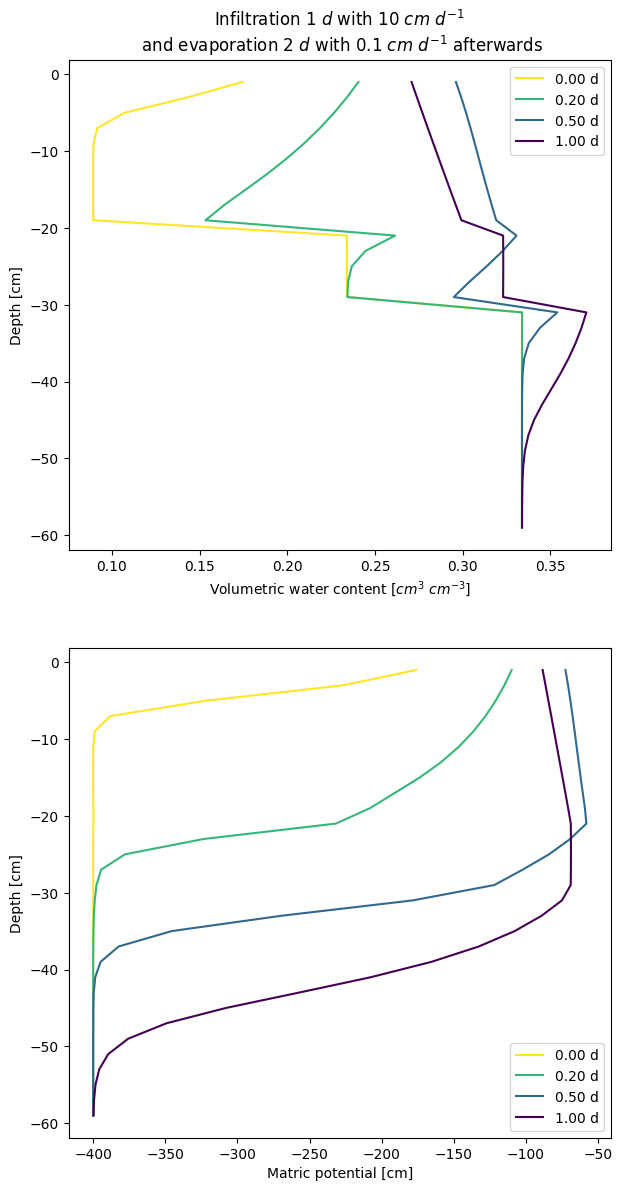

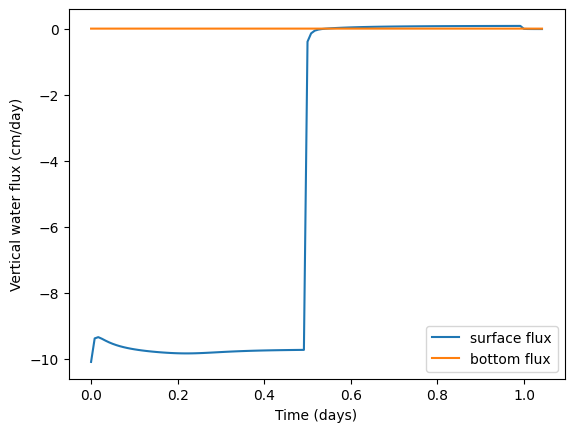

In [ ]:
# Define Mualem van Genuchten parameters for Selhausen soil profile according to Bauer et al. (2011, table 3, \url{https://doi.org/10.1007/s10533-011-9583-1}) |\label{l61ies:genuchten_a}|
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
l1 = [0.008, 0.389, 0.012, 1.97, 91.68]  # 0-20 cm 
l2 = [0.008, 0.389, 0.023, 1.23, 63.36]  # 20-30 cm
l3 = [0.008, 0.389, 0.01, 1.1, 10]  # 30-60 cm

soil = [l1, l2, l3] # Combine the hydraulic conductivity vectors from all soil layers to define soil type for simulation  
sim_time = 1.05  # 3.05
dt = 720 / (24 * 3600)  # time step [days] # 0.05

# Solve the Richards equation using the Python wrapper of dumux-rosi
s = RichardsWrapper(RichardsSPnum())  
s.initialize()
s.setTopBC("atmospheric", 0.5, [[ 0., 0.5,  0.5,   1., 1., 1.e6], 
                                [10., 10., -0.1, -0.1, 0., 0.]])  #  [cm/day] atmospheric is with surface run-off  
s.setBotBC("freeDrainage") 

N = 30   # use a fine grid resolution of 1 mm per grid point in z direction 
s.createGrid([-5., -5., -60.], [5., 5., 0.], [1, 1, N])  # [cm] N   

# define soil layers
layers_ID = [3, 3, 2, 2, 1, 1]  
layers_pos = [-60.,-30., -30, -20, -20, 0] 
s.setLayersZ(layers_ID, layers_pos)
s.setHomogeneousIC(-400.)  # cm homogenous pressure head
s.setVGParameters(soil) 
s.initializeProblem()  
s.setCriticalPressure(-15000)  
s.ddt = 1.e-5  # initial dumux time step [days]

top_ind = s.pick([0., 0., -0.5])
bot_ind = s.pick([0., 0., -59.5])  
top_new, bot_new, soil_times = [], [], []

N = int(np.ceil(sim_time / dt))  
z_, x_, h_ = [], [], []  # initialize solution vectors

wall_iteration = timeit.default_timer()
for i in range(0, N):
    s.ddt = 1.e-5  # initial dumux time step [days]
    t = i * dt  # current simulation time
    soil_times.append(t)
    s.solve(dt)
    if i % 10 == 0:
        print(f"***** external time step: {dt} d, simulation time: {s.simTime} d, internal time step: {s.ddt} d")

    velocities = s.getVelocities_()
    top_new.append(velocities[top_ind])
    bot_new.append(velocities[bot_ind])

    points = s.getDofCoordinates()  # coordinates
    theta = s.getWaterContent()  # volumetric water content
    h = s.getSolutionHead()  # matric potential [cm]
    z_.append(points[:, 2])
    x_.append(theta)
    h_.append(h)
    
wall_iteration = timeit.default_timer() - wall_iteration
top_new = np.array(top_new)
bot_new = np.array(bot_new)
soil_times = np.array(soil_times)

sel_idx = np.searchsorted(soil_times, [0., 0.2, 0.5, 1.]) #, 1.2, 2., 3.]) # define output times

# Plot solutions 
fig1, axs = plt.subplots(2, 1, figsize = (7, 14))
cmap = plt.cm.viridis  # or 'plasma', 'cividis', 'Blues'
cols = cmap(np.linspace(0, 1, len(sel_idx)))
cols = cols[::-1]
for ii, i in enumerate(sel_idx):
    axs[0].plot(x_[i], z_[i], color = cols[ii], label = f'{soil_times[i]:.2f} d')
    axs[1].plot(h_[i], z_[i], color = cols[ii], label = f'{soil_times[i]:.2f} d')

axs[0].set_title("Infiltration 1 $d$ with 10 $cm$ $d^{-1}$ \n and evaporation 2 $d$ with 0.1 $cm$ $d^{-1}$ afterwards")
axs[0].set_xlabel('Volumetric water content [$cm^{3}$ $cm^{-3}$]')
axs[0].set_ylabel('Depth [cm]')
axs[1].set_xlabel('Matric potential [cm]')
axs[1].set_ylabel('Depth [cm]')
axs[0].legend(loc = "best")
axs[1].legend(loc = "best")

plt.show()

plt.figure(1)
plt.plot(soil_times, top_new[:, 2], label = "surface flux")
plt.plot(soil_times, bot_new[:, 2], label = "bottom flux")
plt.xlabel('Time (days)')
plt.ylabel('Vertical water flux (cm/day)')
plt.legend()
plt.show()


### Water uptake by a single root in 1D axisymmetric geometry



area per cell [cm2] [[0.0014192 ]
 [0.00302198]
 [0.00643488]
 [0.01370219]
 [0.0291769 ]
 [0.06212813]
 [0.13229317]
 [0.28169983]
 [0.59984045]]
Distance from root surface [cm] [[0.02459233]
 [0.03588593]
 [0.05236593]
 [0.07641408]
 [0.11150593]
 [0.16271312]
 [0.23743632]
 [0.34647486]
 [0.50558748]]

domain water volume 2.4618629269006114 cm3/cm  =  0.0024618629269006114 l/cm
water content to water volume 2.4618629269006114 cm3/cm
 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
domain water volume 1.0964707722756415 cm3/cm  =  0.0010964707722756414 l/cm
change in water volume -1.3653921546249699 cm3/cm =  -0.00136539215462497 l/cm


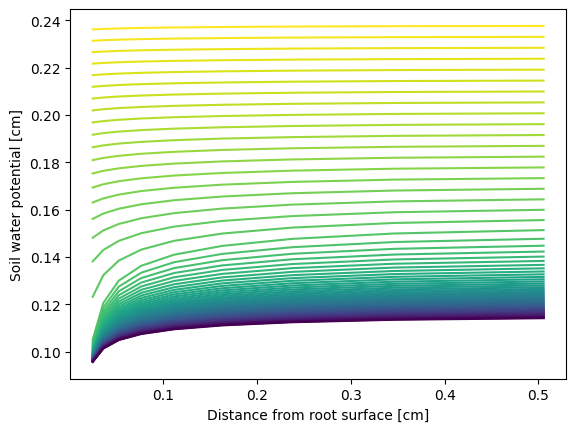

In [ ]:
def plot_profile(cc: np.ndarray, h: np.ndarray, depth: float = -100.) -> None:
    """ 
    Show soil matric potential profile over time.
    
    Args:
        cc (np.ndarray): Cell centers (distance from root surface) [cm].
        h (np.ndarray): Soil matric potential at different times [cm].
        depth (float): Depth at which to plot the profile [cm]."""
    fig, ax1 = plt.subplots()
    n = len(h) // 1
    cmap = plt.cm.viridis  # or 'plasma', 'cividis', 'Blues'
    cols = cmap(np.linspace(0, 1, n))
    cols = cols[::-1]
    for i in range(0, n):
        ax1.plot(cc, h[i * 1], color = cols[i])
    ax1.set_ylabel("Soil water potential [cm]")
    ax1.set_xlabel("Distance from root surface [cm]")

""" Soil """
s = RichardsFlatWrapper(RichardsCylFoam())  # water & single solute
logbase = 0.5
NC = 10  # [1] spatial resolution (1D model)
a_in = 0.02  # cm
a_out = 0.6  # cm
points = np.logspace(np.log(a_in) / np.log(logbase), np.log(a_out) / np.log(logbase), NC, base = logbase)
soil = [0.078, 0.43, 0.036, 1.56, 24.96]  # hydrus loam
s.initialize()
s.createGrid1d(points)
s.setVGParameters([soil])

""" Inital conditions """
s.setHomogeneousIC(-100.)  # [cm] homogeneous pressure head

""" Boundary conditions """
RS_Uptake_Wmax = 1.  # [cm/day]
s.setOuterBC("fluxCyl", 0.)  #  [cm/day] Neumann boundary condition
s.setInnerBC("fluxCyl", 0.)

""" Initialize problem """
s.setParameter("Newton.EnableAbsoluteResidualCriterion", "True")
s.setParameter("Newton.MaxAbsoluteResidual", "1.e-10")
s.setParameter("Newton.SatisfyResidualAndShiftCriterion", "True")
s.setParameter("Newton.EnableChop", "True")
s.initializeProblem()
wilting_point = -10000
s.setCriticalPressure(wilting_point)
s.ddt = 1e-4  # [day] initial Dumux time step

""" Simulation loop """
simtime = 3
dt = 3600. / (24.*3600)
cc = np.array(s.getCellCenters())  # [cm]
points = np.array(s.getPoints())  # [cm] cell faces
area = np.pi * (points[1:] ** 2 - points[:-1] ** 2)  # [cm2] area of each cell
print(f"area per cell [cm2]: {area}")
print(f"Distance from root surface [cm]: {cc}")
theta = np.array(s.getWaterContent())
volume0 = np.sum(np.multiply(theta , area))
print(f"\ndomain water volume: {volume0} cm3/cm  = {volume0 / 1000} l/cm")
print(f"water content to water volume: {volume0} cm3/cm")

N = int(np.ceil(simtime / dt))
h, theta = [], []  # results

for i in range(0, N):
    t = i * dt  # current simulation time

    s.setInnerBC("fluxCyl", -RS_Uptake_Wmax)  # [cm/day]; * sinusoidal(t)
    s.solve(dt)
    h.append(s.getSolutionHead())  # [cm]
    theta.append(s.getWaterContent())  # [1]

volumef = np.sum(np.multiply(theta[-1] , area))
print(f"domain water volume: {volumef} cm3/cm  = {volumef / 1000.} l/cm")
print(f"change in water volume: {volumef - volume0} cm3/cm = {1.e-3 * (volumef - volume0)} l/cm")

plot_profile(cc, theta)
plt.show()
